In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool  = TavilySearchResults(max_results=2)
# tool.invoke("LangGraph에서 '노드'란 무엇인가요?")

In [5]:
from langchain_core.tools import tool
from langgraph.types import interrupt

@tool
def human_assist(query):
    """Human assist tool"""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [7]:
llm = ChatOpenAI(model=openai_model)
tools = [search_tool, human_assist]
llm_with_tools = llm.bind_tools(tools)

In [8]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)

workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("chatbot", tools_condition)
workflow.add_edge("tools", "chatbot")
workflow.add_edge(START, "chatbot")

graph = workflow.compile(checkpointer=memory)

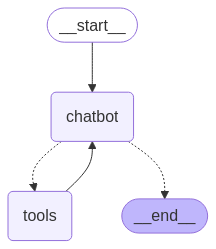

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "user123"}}

#config는 워크플로우에 필요한 어떤 정보든 포함시킬 수 있습니다.
# config = {
#     "configurable": {
#         "thread_id": "user123",
#         "user_name": "홍길동",
#         "language_preference": "korean",
#         "session_start_time": "2025-04-12T10:30:00",
#         "model_settings": {
#             "temperature": 0.7,
#             "top_p": 0.95
#         },
#         "custom_data": {
#             "user_preferences": ["tech", "science", "news"],
#             "subscription_level": "premium"
#         }
#     }
# }

In [16]:
user_input1 = "AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요."
state1 = {"messages": [HumanMessage(content=user_input1)]}
response1 = graph.invoke(state1, config)

print(response1["messages"][-1].content)

LangGraph는 AI 에이전트 개발을 위한 혁신적인 Python 라이브러리로, 다음과 같은 특징을 가지고 있습니다:

1. **그래프 기반 모델링**: LangGraph는 복잡한 워크플로우를 그래프 구조로 모델링합니다. 각 노드는 LLM(대형 언어 모델)에 대한 접근을 나타내며, 엣지는 이러한 노드들 간의 관계를 형성합니다. 이는 에이전트의 복잡한 상호작용을 시각화하고 관리하는 데 유용합니다.

2. **유연성과 확장성**: LangGraph는 다양한 워크플로우를 지원하며, 사용자는 특정 요구에 맞게 원하는 기능을 손쉽게 추가하거나 수정할 수 있습니다. 이러한 유연성 덕분에 다양한 분야에 적합한 에이전트를 개발할 수 있습니다.

3. **상태 관리**: LangGraph는 에이전트의 상태를 효과적으로 관리하는 기능을 제공하여, 다양한 상황에 맞게 에이전트의 행동을 조정할 수 있습니다. 이는 안정적인 작업 흐름을 지원합니다.

4. **간단한 개발 환경**: LangGraph는 직관적인 API를 제공하여 개발자가 빠르고 쉽게 에이전트를 구축하고 테스트할 수 있도록 돕습니다. 이로 인해 AI 모델 및 에이전트 개발 과정이 훨씬 수월해집니다.

5. **사용자 정의 에이전트**: LangGraph는 개발자가 자신의 요구사항에 맞게 사용자 정의 에이전트를 생성할 수 있도록 해줍니다. 이를 통해 필요한 기능을 플러그인처럼 추가하여 특화된 솔루션을 만들 수 있습니다.

6. **재사용성과 모듈화**: 개발자는 이미 구축된 모듈과 기능을 재사용하여 새로운 프로젝트에 빠르게 적용할 수 있습니다. 이는 개발 시간을 단축시키고 일관성을 유지하는 데 도움을 줍니다.

이러한 특징 덕분에 LangGraph는 다양한 산업과 애플리케이션에 적합한 AI 에이전트를 효율적으로 생성하고 관리할 수 있는 강력한 도구로 자리잡고 있습니다.


In [ ]:
from pprint import pprint
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
	pprint(snapshot.values['messages'])
else:
	print("No messages found in the snapshot.")
print(snapshot.next)



# snapshot.next는 LangGraph에서 현재 워크플로우의 다음 실행 노드를 나타냅니다.
# 상태 그래프(StateGraph)에서 get_state 메서드로 얻은 스냅샷(snapshot)에는 두 가지 중요한 정보가 포함됩니다:

# values - 현재 상태의 값들(예: 메시지 기록, 변수 등)
# next - 다음에 실행될 노드의 이름

# 따라서 snapshot.next는 워크플로우가 다음으로 어떤 노드를 실행할 예정인지를 알려줍니다. 이는 워크플로우의 현재 진행 상황을 이해하고 디버깅하는 데 매우 유용합니다.
# 예를 들어:

# snapshot.next가 "chatbot"이라면, 다음에 실행될 노드는 "chatbot" 노드입니다.
# snapshot.next가 "tools"라면, 다음에 실행될 노드는 "tools" 노드입니다.

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='007324ec-3d1d-4124-b5cb-8c3f126ecf4f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfUUWRwkfPuGo2o5Eh7HtYh5', 'function': {'arguments': '{"query":"LangGraph 특징 AI 에이전트 개발"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOcZmLEBr3hUEUMUghfc3SkSbySn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e629d89-325a-40d5-a975-8623687df057-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [18]:
user_input2 = "AI 에이전트 개발을 위한 기술 선택에 대한 전문가의 지원이 필요해요. 지원 요청을 해도 될까요?"
state2 = {"messages": [HumanMessage(content=user_input2)]}
response2 = graph.invoke(state2, config)

print(response2["messages"][-1].content)

In [19]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
	pprint(snapshot.values['messages'])
else:
	print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='007324ec-3d1d-4124-b5cb-8c3f126ecf4f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfUUWRwkfPuGo2o5Eh7HtYh5', 'function': {'arguments': '{"query":"LangGraph 특징 AI 에이전트 개발"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOcZmLEBr3hUEUMUghfc3SkSbySn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e629d89-325a-40d5-a975-8623687df057-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [20]:
from langgraph.types import Command

human_response = (
    "네, 물론입니다. AI 에이전트 개발을 위한 기술 선택에 대한 지원을 해드리겠습니다. "
    "우선 LangGraph를 사용하는 것에 대해 어떻게 생각하시나요? "
    "LangGraph는 AI 에이전트를 개발하는 데 매우 유용한 도구입니다. "
)

human_command = Command(resume={"data": human_response})
response = graph.invoke(human_command, config)
print(response["messages"][-1].content)

AI 에이전트 개발을 위한 기술 선택에 대해 전문가의 지원을 요청하는 것은 좋은 접근입니다. LangGraph와 같은 도구는 효율적인 에이전트 개발에 큰 도움이 될 수 있으므로, 이 도구의 사용을 고려해 보시면 좋겠습니다.

기술 선택에 있어 고려해야 할 몇 가지 요소는 다음과 같습니다:

1. **프로젝트 요구사항**: 개발할 에이전트의 기능성과 목표를 명확히 설정하세요.
2. **개발 팀의 기술 스택**: 팀원의 경험과 기존 사용 중인 기술 스택이 어떤 것인지 파악하여 기술 선택에 반영하세요.
3. **확장성과 유지보수**: 선택한 기술이 프로젝트의 확장성 및 유지보수에 적합한지 평가하세요.
4. **커뮤니티 및 문서화**: 기술의 커뮤니티 지원과 문서화 수준도 고려해야 하며, 이는 문제 해결에 큰 도움이 됩니다.
5. **비용**: 라이선스 비용이나 인프라 비용을 포함하여 예산을 고려하세요.

이런 점들을 종합적으로 고려하여 기술 선택에 대한 결정을 내리시는 것이 중요합니다. 필요하시다면 더 구체적인 조언이나 정보를 요청하셔도 좋습니다!


In [23]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='007324ec-3d1d-4124-b5cb-8c3f126ecf4f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfUUWRwkfPuGo2o5Eh7HtYh5', 'function': {'arguments': '{"query":"LangGraph 특징 AI 에이전트 개발"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOcZmLEBr3hUEUMUghfc3SkSbySn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e629d89-325a-40d5-a975-8623687df057-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [24]:
user_input3 = "앞서 추천해주신 기술의 시장성은 어떤가요?"
state3 = {"messages": [HumanMessage(content=user_input3)]}
response3 = graph.invoke(state3, config)

print(response3["messages"][-1].content)

LangGraph의 시장성은 매우 유망한 것으로 평가되고 있습니다. 다음은 그 이유를 설명하는 몇 가지 포인트입니다:

1. **사용률 증가**: 최근 데이터에 따르면, LangGraph의 사용률이 빠르게 증가하고 있습니다. 예를 들어, 2024년 초에 약 7%의 사용자 비율이었으나, 연말에는 44%로 증가한 것으로 보아 많은 개발자들이 LangGraph를 채택하고 있다는 것을 알 수 있습니다. 이는 시장에서의 신뢰성과 효과성을 나타냅니다.

2. **다양한 활용 사례**: LangGraph는 다양한 산업에서 AI 에이전트를 위한 자동화 솔루션으로 활용되고 있습니다. 예를 들어, 암호화폐 거래소에서는 LangGraph와 n8n을 결합하여 시장 변동성을 감지하고 거래 전략을 조정하는 시스템을 개발한 사례가 있습니다. 이는 LangGraph가 실제 비즈니스 환경에서도 효과적으로 사용될 수 있음을 보여줍니다.

3. **생태계와 Community**: LangGraph는 활발한 커뮤니티와 생태계가 형성되어 있어, 사용자들이 쉽게 정보를 공유하고 문제를 해결할 수 있는 환경이 조성되어 있습니다. 이는 기술의 지속적인 발전과 안정성에 긍정적인 영향을 미칩니다.

4. **진화하는 요구**: AI와 자동화 기술에 대한 수요가 계속해서 증가하고 있는 가운데, LangGraph 같은 플랫폼은 개발자들에게 필요한 도구와 기능을 제공하여 시장에서의 경쟁력을 유지하고 있습니다.

결론적으로, LangGraph는 현재 및 미래의 AI 에이전트 개발에 있어 강력한 시장성을 가지고 있으며, 다양한 분야에서 그 활용 가능성이 크게 확대될 것으로 기대됩니다.


In [25]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='007324ec-3d1d-4124-b5cb-8c3f126ecf4f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfUUWRwkfPuGo2o5Eh7HtYh5', 'function': {'arguments': '{"query":"LangGraph 특징 AI 에이전트 개발"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOcZmLEBr3hUEUMUghfc3SkSbySn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e629d89-325a-40d5-a975-8623687df057-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [26]:
user_input4 = "LangGraph의 메모리 기능 추가에 대한 전문가의 지원이 필요해요."
state4 = {"messages": [HumanMessage(content=user_input4)]}
response4 = graph.invoke(state4, config)

print(response4["messages"][-1].content)

In [27]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
	pprint(snapshot.values['messages'])
else:
	print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='007324ec-3d1d-4124-b5cb-8c3f126ecf4f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfUUWRwkfPuGo2o5Eh7HtYh5', 'function': {'arguments': '{"query":"LangGraph 특징 AI 에이전트 개발"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOcZmLEBr3hUEUMUghfc3SkSbySn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e629d89-325a-40d5-a975-8623687df057-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [28]:
human_response = (
    "MemorySaver는 메모리 기반의 체크포인터로, 각 대화의 상태를 메모리에 임시로 저장하고 관리합니다. "
    "이를 통해 챗봇은 이전 대화 내용을 기억하고 다음 번 상호작용 시에도 맥락을 유지한 상태로 대화를 진행할 수 있습니다. "
    "실제 운영 환경에서는 더 영구적인 상태 관리를 위해 데이터베이스 기반 체크포인터(예: SqliteSaver 또는 PostgresSaver)를 사용하는 것이 권장됩니다."
)

human_command = Command(resume={"data": human_response})
response = graph.invoke(human_command, config)
print(response["messages"][-1].content)

LangGraph의 메모리 기능 추가에 대한 지원 요청에 대해 다음과 같은 전문가 의견을 드립니다.

### 메모리 기능 개요
MemorySaver는 LangGraph의 메모리 기반 체크포인터로, 각 대화의 상태를 임시로 저장하고 관리할 수 있는 기능입니다. 이를 통해 챗봇은 사용자의 이전 대화 내용을 기억하고, 다음 상호작용에서도 맥락을 유지할 수 있습니다. 이는 사용자 경험을 크게 향상시키는 요소입니다.

### 바람직한 접근 방식
1. **임시 메모리 사용**: 초기 단계에서는 MemorySaver와 같은 메모리 기반 체크포인터를 사용하여 대화의 상태를 유지할 수 있습니다. 이 방식은 구현이 비교적 간단하며, 초기 프로토타입이나 테스트 모델에 적합합니다.

2. **영구적인 상태 관리**: 운영 환경에서는 데이터를 보다 영구적으로 저장하기 위해 데이터베이스 기반 체크포인터 사용을 고려하는 것이 좋습니다. 예를 들어:
   - **SqliteSaver**: 작고 경량화된 데이터베이스로, 간단한 데이터 저장에 적합하며, 설정이 간편합니다.
   - **PostgresSaver**: 스케일이 큰 데이터 처리가 필요한 경우 안정성이 뛰어난 데이터베이스입니다.

3. **범위 설정**: 메모리에 저장할 데이터의 범위와 데이터 유지를 위한 정책을 설정하세요. 예를 들어, 사용자별 대화 기록을 저장할 것인지, 특정 기간 동안의 대화만 유지할 것인지 등을 결정하는 것이 중요합니다.

4. **데이터 보안 및 프라이버시**: 사용자 데이터를 저장하는 경우, 안전한 저장 방식과 데이터 암호화 방식 등을 고려하여 개인정보 보호를 위해 신뢰할 수 있는 조치를 취해야 합니다.

5. **테스트 및 검증**: 메모리 기능을 추가한 후, 실제 시나리오에서의 테스트를 통해 기능이 올바르게 작동하는지 검증하는 것이 필수적입니다.

이러한 접근 방식을 통해 LangGraph의 메모리 기능을 효과적으로 추가하고, 사용자 경험을 개선할 수 있습니다. 추가적인 상담이나 지원이 필요하시면 언제

In [29]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='007324ec-3d1d-4124-b5cb-8c3f126ecf4f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZfUUWRwkfPuGo2o5Eh7HtYh5', 'function': {'arguments': '{"query":"LangGraph 특징 AI 에이전트 개발"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOcZmLEBr3hUEUMUghfc3SkSbySn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e629d89-325a-40d5-a975-8623687df057-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '